In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [4]:
import sys
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import alphashape
import scanpy as sc
import pandas as pd

In [5]:
sys.path.append('../src')
from spaceoracle.tools.utils import scale_adata
from spaceoracle.models.parallel_estimators import init_received_ligands


In [39]:
# # Human Tonsil snRNAseq from SlideTags
# # https://www.nature.com/articles/s41586-023-06837-4

# adata_tmp = sc.read_h5ad('/Volumes/SSD/training_data/snrna_human_tonsil.h5ad')
# adata_tmp.obs = adata_tmp.obs.join(pd.read_csv(
#     '/Users/koush/Projects/SpaceOracle copy/manuscript/human_tonsil_slidetags/tonsil_cell_types.csv', 
#     index_col=0))

# # sc.pp.pca(adata_tmp)
# # sc.pp.neighbors(adata_tmp)

# adata_tmp

adata = sc.read_h5ad('../data/snrna_germinal_center.h5ad')
adata

AnnData object with n_obs × n_vars = 1466 × 3333
    obs: 'cell_type', 'cell_type_2'
    obsm: 'X_umap', 'spatial'

In [49]:
xy = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names)
xy.columns = ['x', 'y']

In [ ]:
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150


ct_points_wt = {}
for ct in adata.obs['cell_type_major'].unique():
    points = np.asarray(
        adata[adata.obs['cell_type_major'] == ct].obsm['spatial'])
    delta = 30
    points = np.vstack(
        (points +[-delta,delta], points +[-delta,-delta], 
        points +[delta,delta], points +[delta,-delta]))
    ct_points_wt[ct] = points

In [14]:
color_dict = {
    "GC Dark Zone": "#f14e13",
    "GC Light Zone": "#0feca9",
    "GC Intermediate Zone": "#33def1",
    "plasma": "#61c17c",
    "B_naive": "#308f0e",
    "B_memory": "#beb637",
    "B_germinal_center": "#8995cf",
    "Naive CD4 T": "#f721b7",
    "Treg": "#ecc91d",
    "T memory": "#49f12f",
    "Th1": "#c43cf2",
    "Th2": "#061bb5",
    "T_CD8": "#dd3652",
    "T_CD4": "#2b07f6",
    "T_follicular_helper": "#e28723",
    "mDC": "#a5a29e",
    "FDC": "#a5a29e",
    "myeloid": "#a5a29e",
    "NK": "#a5a29e",
    "pDC": "#a5a29e",
    "T_double_neg": "#a5a29e",
    "Germinal Center B cells": "#6295cd",
    "Plasma cells": "#58a862",
    "T cells": "#cc5343",
    "B cells": "#9865c8",
    "Dendritic cells": "#9da13c",
    "Myeloid cells": "#f3c009",
    "NK cells": "#a36e29",
}

In [69]:
%matplotlib inline

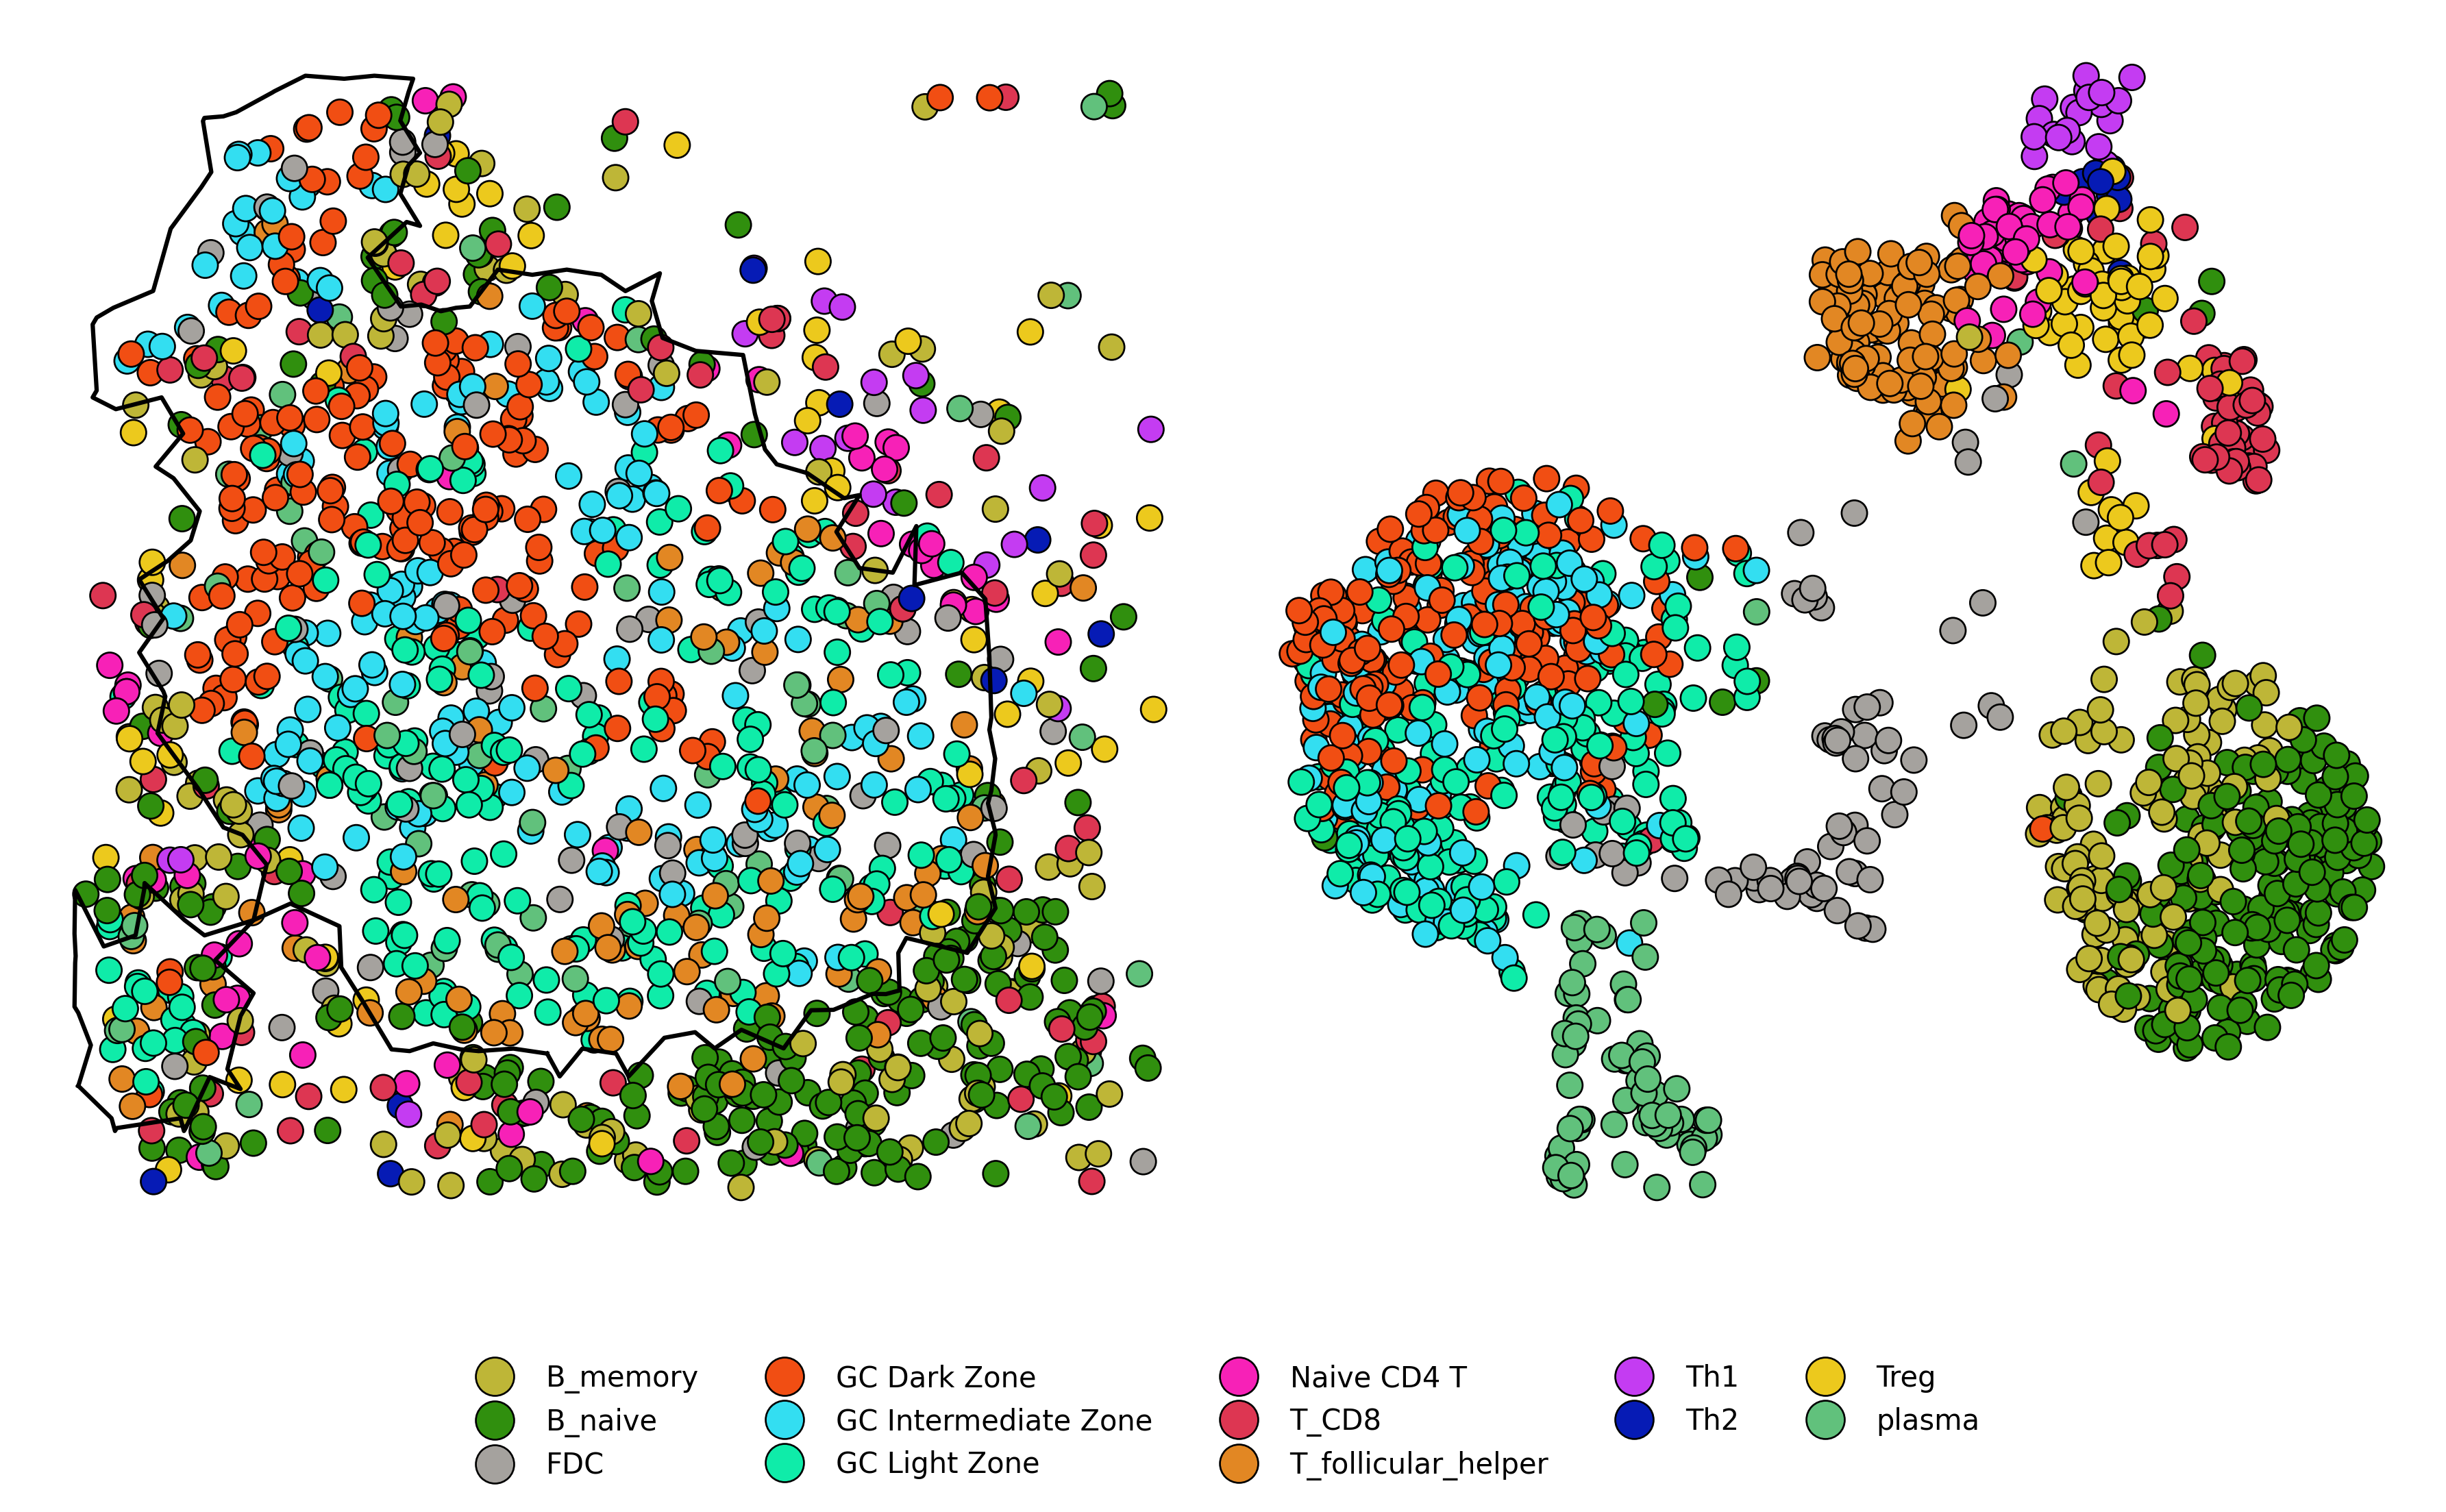

In [71]:
adata = adata[adata.obs['cell_type_2'].isin(
        [
            'B_naive', 'B_memory',
            'GC Light Zone', 'GC Dark Zone', 'GC Intermediate Zone',
            'T_follicular_helper', 'FDC', 'plasma', 'T_CD8', 'Treg',
            'Naive CD4 T', 'Th1', 'Th2'
        ]
    )
]

annot = 'cell_type_2'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6.25))

sns.scatterplot(data=adata.obs, 
    x=adata.obsm['spatial'][:,0], 
    y=adata.obsm['spatial'][:,1],
    s=80,
    hue=annot,
    linewidth=0.65,
    edgecolor='black',
    legend='brief', 
    palette=color_dict,
    ax=ax1
)

ax1.axis('off')

alpha_shape = alphashape.alphashape(
    ct_points_wt['Germinal Center B cells'], alpha=0.035)
for geom in alpha_shape.geoms:
    if geom.area > 10000:
        ax1.plot(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color='black', alpha=1
        )

sns.scatterplot(data=adata.obs, 
    x=adata.obsm['X_umap'][:,0], 
    y=adata.obsm['X_umap'][:,1],
    s=80,
    hue='cell_type_2',
    linewidth=0.65,
    edgecolor='black',
    legend=False, 
    palette=color_dict,
    ax=ax2
)
ax2.axis('off')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels,
    bbox_to_anchor=(0.5, -0.05), 
    loc='upper center', 
    ncol=5, 
    frameon=False, 
    markerscale=1.5, 
    fontsize=10
)

ax1.get_legend().remove()
if ax2.get_legend():
    ax2.get_legend().remove()

plt.tight_layout()
plt.show()

In [40]:
from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator
from spaceoracle.tools.network import RegulatoryFactory
from spaceoracle.oracles import BaseTravLR

In [41]:
co_grn = RegulatoryFactory(
    colinks_path='/Volumes/SSD/training_data/snrna_human_tonsil_colinks.pkl',
    annot='cell_type_int'
)

In [42]:
co_grn.get_regulators(adata, 'AICDA')

['DBP', 'FOXS1', 'GATA3', 'KLF2', 'KLF3', 'PAX5', 'RFX8', 'STAT3', 'TWIST1']

In [43]:
adata.layers['normalized_count'] = adata.X.toarray().copy()

In [44]:
adata

AnnData object with n_obs × n_vars = 1466 × 3333
    obs: 'cell_type', 'cell_type_2'
    obsm: 'X_umap', 'spatial'
    layers: 'normalized_count'

In [45]:
BaseTravLR.impute_clusterwise(
    adata, 
    annot='cell_type', 
    layer='normalized_count', 
    layer_added='imputed_count'
)

In [46]:
from spaceoracle.tools.network import encode_labels

In [47]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type_int'] = adata.obs['cell_type'].apply(
    lambda x: encode_labels(adata.obs['cell_type'], reverse_dict=True)[x])

adata

AnnData object with n_obs × n_vars = 1466 × 3333
    obs: 'cell_type', 'cell_type_2', 'cell_type_int'
    obsm: 'X_umap', 'spatial'
    layers: 'normalized_count', 'imputed_count'

In [162]:
estimator = SpatialCellularProgramsEstimator(
    adata, 
    target_gene='CXCR4', 
    cluster_annot='cell_type_int',
    radius=250, 
    contact_distance=30, 
    grn=co_grn
)

In [163]:
estimator.fit(
    num_epochs=50, 
    threshold_lambda=1e-4, 
    learning_rate=5e-3, 
    batch_size=256, 
    estimator='lasso',
    vision_model='cnn',
    score_threshold=0.2, 
    l1_reg=1e-9,
)

Fitting CXCR4 with 1115 modulators
	44 Transcription Factors
	946 Ligand-Receptor Pairs
	125 TranscriptionFactor-Ligand Pairs
0: 0.5553 | 0.6036
1: 0.8303 | 0.9954
2: 0.9409 | 0.9517
3: 0.8765 | 0.9607
4: 0.9819 | 0.9844


In [164]:
betadata = estimator.betadata

In [165]:
xy = pd.DataFrame(estimator.xy, index=adata.obs_names, columns=['x', 'y'])

In [169]:
[i for i in betadata.columns if 'FOX' in i]

['beta_FOXS1', 'beta_TGFB1#FOXS1', 'beta_ANGPTL4#FOXS1', 'beta_JAG1#FOXS1']

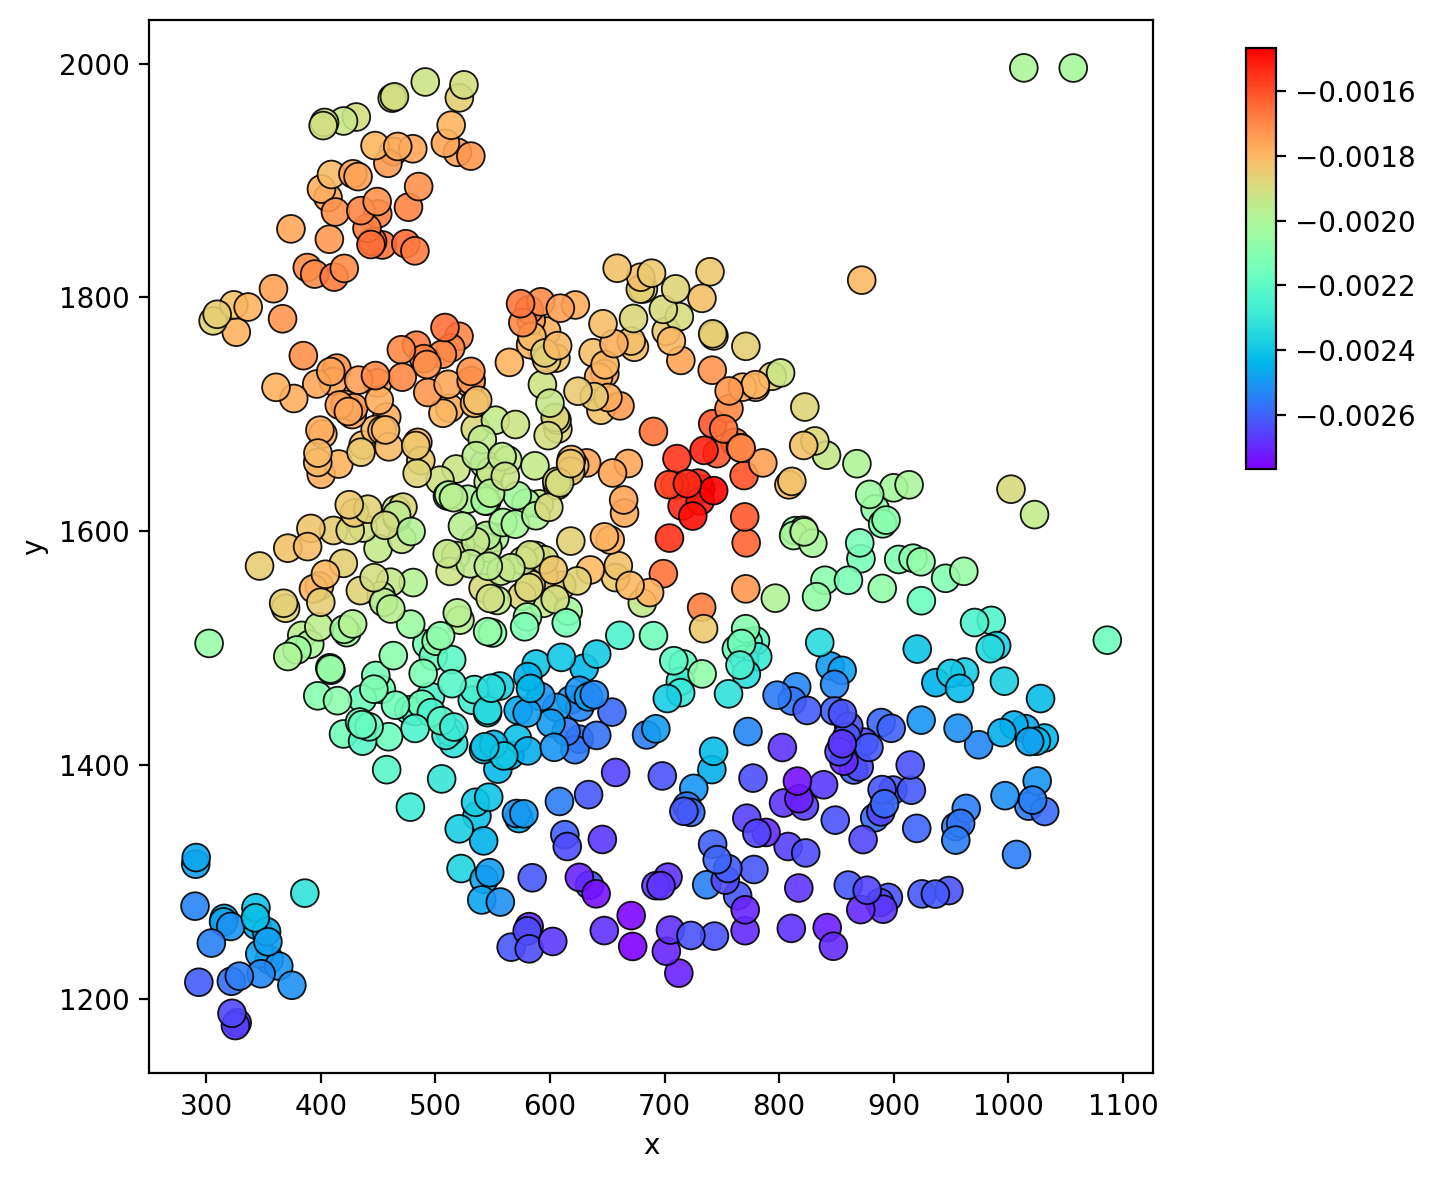

In [172]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Prepare the data
light_zone_mask = adata.obs['cell_type_2'].str.contains('GC')
light_zone = betadata[light_zone_mask].join(xy)

beta = 'beta_FOXS1'
# beta = 'beta_IL4$IL4R'

fig, ax = plt.subplots(figsize=(6, 6))

# Plot only GC Light Zone
norm = mpl.colors.Normalize(
    vmin=light_zone[beta].min(),
    vmax=light_zone[beta].max(),
)
sc = ax.scatter(
    light_zone['x'], light_zone['y'],
    c=light_zone[beta], cmap="rainbow", norm=norm, s=100,
    edgecolor='black', linewidth=0.65, label="GC Light Zone", alpha=0.9
)

ax.set_xlabel('x')
ax.set_ylabel('y')

# Colorbar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbar_ax = inset_axes(ax, width="3%", height="40%", loc='upper right', bbox_to_anchor=(0.15, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=1)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="rainbow"), cax=cbar_ax)

plt.tight_layout()
plt.show()

In [131]:
betadata[adata.obs['cell_type_int'] == 4].var().sort_values(ascending=False)

beta_TGFB1$TGFBR1     1.383111e-06
beta_MIF$CD44         1.019169e-06
beta_RFX8             8.281673e-07
beta_ANGPTL1$ITGA1    6.403283e-07
beta_TGFB1$TGFBR2     4.270068e-07
                          ...     
beta_LAMA2$ITGA9      0.000000e+00
beta_LAMA3$ITGA9      0.000000e+00
beta_LAMA4$ITGA9      0.000000e+00
beta_LAMA5$ITGA9      0.000000e+00
beta_IL6#TWIST1       0.000000e+00
Length: 980, dtype: float32

In [128]:
pd.DataFrame(estimator.models[4].anchors.cpu().detach().numpy(), index=betadata.columns).loc[beta]

0    0.155114
Name: beta_IL21$IL21R, dtype: float32